in this notebook I calculated avg number of words in requests set and in adverts set.
then researched unique words in both dataset and compare this number

1 I get lemma for each words in adverts and request
2 put all lemmas in one bag of words
3 calculate part of most popular words (for example top20 word is eauale 16% of unique words)
4 The most popular words is transformed to stop-list. I think this words are less usefull, but demand resources.
5 Exlude stop-words from advertsset
6 check metrics

# Preparation

In [1]:
import sys
import os
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '..')))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from dataset_tools.utils import load_matching_data
from research.metrics import confusion_matrix_micro, evaluate
from tqdm import tqdm

from typing import List
import pymorphy3

In [3]:
# %%time
# !python -m spacy download ru_core_news_lg

# Data

In [4]:
requests_file = "../data/request_db.txt"
ads_file = "../data/ads_db.txt"
matching_file = "../data/matching_db.txt"

In [5]:
with open(ads_file, encoding="utf-8") as f:
    ads_raw = f.readlines()

In [6]:
with open(requests_file, encoding="utf-8") as f:
    requests_raw = f.readlines()

# Preprocessing

In [7]:
# nlp = spacy.load("ru_core_news_lg")

In [8]:
def preprocessing(text):
    text = text.replace("\\n", "\n").replace("\n", " ")
    text = text.strip()
    text = text.lower()  # many words has vectors inly in lowercase
    return text

In [9]:
morph = pymorphy3.MorphAnalyzer()

def lemmatizer(morph, text):
    return morph.parse(text)[0].normal_form
    
def flat_lemma(morph, texts):
    texts_prepared = [preprocessing(text) for text in texts]

    result_intermediate = []
    result = []
    for line in texts_prepared:
        text_lemma = [lemmatizer(morph, text) for text in line.split()]
        result_intermediate.append(text_lemma)
        for word in text_lemma:
            result.append(word)

    return result, result_intermediate

In [10]:
# get list of text
ads_lemma, ads_lemma_ = flat_lemma(morph, ads_raw)
requests_lemma, requests_lemma_ = flat_lemma(morph, requests_raw)

In [11]:
# count word in each advert and request
count_adv = []
count_req = []

for text in ads_lemma_:
    count_adv.append(len(text))


for text in requests_lemma_:
    count_req.append(len(text))

look at distribution for numbers of word in advert and request

In [12]:
import plotly.graph_objs as go

def plot_compare_distributions(data1, data2, label1='Distribution 1', label2='Distribution 2', bins=30, name_title = None):
    fig = go.Figure()

    fig.add_trace(go.Histogram(x=data1, nbinsx=bins, name=label1, opacity=0.6))
    fig.add_trace(go.Histogram(x=data2, nbinsx=bins, name=label2, opacity=0.6))

    fig.update_layout(barmode='overlay',
                      title=name_title,
                      xaxis_title='Value',
                      yaxis_title='Count',
                      legend_title='Distributions')
    
    fig.show()

In [13]:
plot_compare_distributions(count_adv,
                           count_req,
                           label1='Number of word in advert',
                           label2='Number of word in request',
                           bins=100,
                           name_title = "Distribution of word's number")

In [14]:
ads_lemma_unique = list(set(ads_lemma))
req_lemma_unique = list(set(requests_lemma))

In [15]:
# число уникальных слов в объявлениях и в запросах
# number of unique words in adverts and in requests
print("ads", len(ads_lemma_unique))
print("request", len(req_lemma_unique))

ads 5597
request 430


In [16]:
# общее число слов в объявлениях и в запросах
# total number of words in adverts and in requests

print("ads raw", len(ads_lemma))
print("request raw" , len(requests_lemma))

ads raw 12186
request raw 894


In [17]:
# research most popular word in advert
df_ads_lemma = pd.DataFrame(ads_lemma)

In [18]:
# calculate part of the most popular words 

most_frequance_words = []

for slice in range(5,100,5):
    freq_value = np.sum(df_ads_lemma.value_counts().head(slice)/df_ads_lemma.shape[0])
    most_frequance_words.append(freq_value)

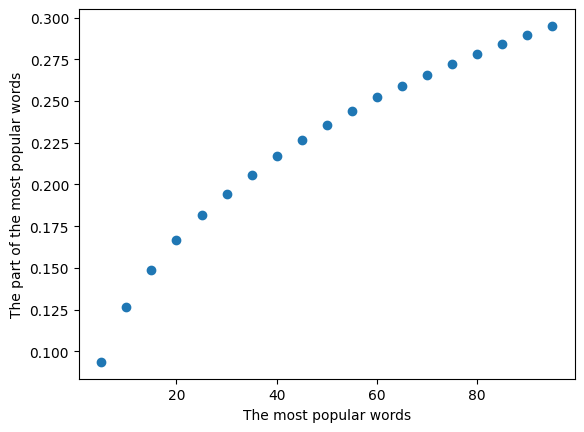

In [19]:
plt.scatter(range(5,100,5), most_frequance_words)
plt.xlabel("The most popular words")
plt.ylabel("The part of the most popular words")
plt.show()

In [20]:
stop_words = list(df_ads_lemma.value_counts().head(50).index.values)

In [21]:
stop_words = [word[0] for word in stop_words]

# Here base pipeline started

In [22]:
nlp = spacy.load("ru_core_news_lg")

In [23]:
def exclude_stop_words(morph, line:str, stop_words:List[str]):
    """function check words in line and exlude word in stop list
    """
    line = [lemmatizer(morph, word) for word in line.split()]
    line = [word for word in line if word not in stop_words] 
    line = ' '.join(line)

    return line

def each_word_to_nlp(line:str):
    """ split each advert to word and each word transform to vector (to spacy data format) 
    """

    return [nlp(word) for word in line.split()]

In [24]:
# get list of text
ads_text = [preprocessing(text) for text in ads_raw]
ads_text = [exclude_stop_words(morph, text, stop_words) for text in ads_text]

# get list of word embedings from text --- list of text > each text split to word > each word transform to vector
ads = [each_word_to_nlp(line) for line in ads_text] # vector 

In [25]:
ads_ = [nlp(preprocessing(text)) for text in ads_text] # baseline vector with changes include lemma and exclude top stop_words

In [26]:
requests = [nlp(preprocessing(text)) for text in requests_raw]

In [27]:
for request in requests:
    if not request.has_vector:
        print(request) 

снуд вязанный
дкарандши
беговел
экомешочки
шифонер
электросамокат
самосбор
онтоновка
безсахара
уходовая кометика
вейп
фотостудия
автолюлька
автокресло
чермет


# Predict

In [28]:
def similarity(a, b):
    if isinstance(a, spacy.tokens.doc.Doc) and isinstance(b, spacy.tokens.doc.Doc): 
        return a.similarity(b)
    else:
        return np.dot(a, b) / np.dot(np.linalg.norm(a), np.linalg.norm(b))

In [29]:
def sim_request(request, ads):
    return [similarity(request, ad) for ad in ads]



In [30]:
def find_indices(scores, threshold):
    if isinstance(scores, np.ndarray):
        return np.where(scores > threshold)[0]
    else:
        return [i for i, score in enumerate(scores) if score > threshold]

In [31]:
# as i noticed in my experiment with "the cabachok"
# even similarity less than 0.5 for advert look like right way
# and the reason maybe too long advert (too much words)
# split advert on two equal part and calculate SIMILRAITY

def similarity_word(requests:spacy.tokens.doc.Doc, ad:List[spacy.tokens.doc.Doc]):

    """
    calculate similraty for each word in advert
    """
    score = 0
    
    for word in ad:    
        if similarity(request.vector, word.vector) >= score:
            score = similarity(request, word) 
    
    return score

def sim_request_word(request:spacy.tokens.doc.Doc, ads:List[List[spacy.tokens.doc.Doc]]):
    return [np.max(similarity_word(request, ad)) for ad in ads]


In [32]:
def predict(requests, ads, threshold=0.5):
    predictions = {}
    for i, request in enumerate(requests):
        scores = sim_request(request, ads)
        indices = find_indices(scores, threshold)
        if indices:
            predictions[str(i+1)] = [str(idx+1) for idx in indices] # indexation starts from 1 in the mapping
    return predictions

In [33]:
def predict_upd(requests, ads, threshold=0.4):
    predictions = {}
    for i, request in enumerate(tqdm(requests)):
        scores = sim_request_word(request, ads)
        indices = find_indices(scores, threshold)
        if indices:
            predictions[str(i+1)] = [str(idx+1) for idx in indices] # indexation starts from 1 in the mapping
    return predictions

In [34]:
predictions = predict(requests, ads_, threshold=0.4)

/var/folders/5d/1272b4cx2bq915491_d55y0c0000gn/T/ipykernel_8808/1724441823.py:3: UserWarning:

[W008] Evaluating Doc.similarity based on empty vectors.



In [35]:
predictions_ = predict_upd(requests, ads, threshold=0.4)

  0%|          | 0/357 [00:00<?, ?it/s]/var/folders/5d/1272b4cx2bq915491_d55y0c0000gn/T/ipykernel_8808/1724441823.py:5: RuntimeWarning:

invalid value encountered in scalar divide

100%|██████████| 357/357 [00:55<00:00,  6.38it/s]


# Evaluation

## Example Data

In [36]:
ex_mapping = {"1": ["1", "4"],
     "3": ["7"],
     "4": ["3", "1", "5"]
    }

ex_predictions = {"1": ["1", "8", "4"],
     "3": ["7"],
     "5": ["10"]
    }

ex_n_ads = 10
ex_n_requests = 5

ex = """
1)  1 2 3 4 5 6 7 8 9 10
map 1 0 0 1 0 0 0 0 0 0 
pr  1 0 0 1 0 0 0 1 0 0

2)  1 2 3 4 5 6 7 8 9 10
map 0 0 0 0 0 0 0 0 0 0 
pr  0 0 0 0 0 0 0 0 0 0

3)  1 2 3 4 5 6 7 8 9 10
map 0 0 0 0 0 0 1 0 0 0 
pr  0 0 0 0 0 0 1 0 0 0

4)  1 2 3 4 5 6 7 8 9 10
map 1 0 1 0 1 0 0 0 0 0 
pr  0 0 0 0 0 0 0 0 0 0

5)  1 2 3 4 5 6 7 8 9 10
map 0 0 0 0 0 0 0 0 0 0 
pr  0 0 0 0 0 0 0 0 0 1

MICRO MATRIX:
TP: 3
FP: 2
TN: 42
FN: 3
"""

In [37]:
ex_confusion_matrix = confusion_matrix_micro(ex_mapping, ex_predictions, n_ads=ex_n_ads, n_requests=ex_n_requests)
ex_confusion_matrix

{'TP': 3, 'FP': 2, 'TN': 42, 'FN': 3}

In [38]:
evaluate(ex_confusion_matrix)

{'accuracy': 3.84, 'precision': 0.6, 'recall': 0.5, 'f1': 0.5454545454545454}

## Real Data

In [39]:
mapping = load_matching_data(matching_file)

In [40]:
confusion_matrix = confusion_matrix_micro(mapping, predictions, n_ads=len(ads_), n_requests=len(requests))
confusion_matrix

{'TP': 193, 'FP': 4234, 'TN': 83210, 'FN': 185}

In [41]:
evaluate(confusion_matrix, ndigits=3)

{'accuracy': 193.947, 'precision': 0.044, 'recall': 0.511, 'f1': 0.08}

# experiment <br>
 with exlude stop_list

In [42]:
confusion_matrix_ = confusion_matrix_micro(mapping, predictions_, n_ads=len(ads_), n_requests=len(requests))
confusion_matrix_

{'TP': 24, 'FP': 3903, 'TN': 83541, 'FN': 354}

In [43]:
evaluate(confusion_matrix_, ndigits=3)

{'accuracy': 24.951, 'precision': 0.006, 'recall': 0.063, 'f1': 0.011}